In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path

# Function to plot data

In [164]:
def plot_data(dataset, prop):
    '''
    Plot data from mandyoc according to a given property.

    Parameters
    ----------
    fapth: str
           Path to scenario directory.
    
    ax: `~matplotlib.axes._subplots.AxesSubplot` Axis subplot.
    
    axs: 
        Numpy array of `~matplotlib.axes.Axes` list of Axes after use of trim_axis function.

    prop: str
        Property from mandyoc.     

    step: int
        Step of Mandyoc output files .

    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis
    '''
    
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'heat':                 'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'cividis',
#                   'strain': 'Greys',
#                   'strain': 'inferno',
#                   'strain': 'magma',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density':             [0.0, 3378.],
                   'heat':                [np.log10(1.0E-13), np.log10(1.0E-9)],
                   'lithology':           [None, None],
                   'pressure':            [-1.0E-3, 1.0],
                   'strain':              [None, None],
                   'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-12)],
#                    'strain_rate':         [1.0E-19, 1.0E-12],
                   'temperature':         [0, 1600],
                   'temperature_anomaly': [-150, 150],
                   'topography':          [-6, 6],
                   # 'viscosity':           [np.log10(1.0E16), np.log10(1.0E25)],
                   # 'viscosity':           [np.log10(1.0E22), np.log10(1.0E25)],
                   'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
                  }
    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)
    
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout = True)
    val_minmax = vals_minmax[prop]
    
    #dealing with data
    if(prop == 'lithology'):
        data = dataset['strain']
        
    elif(prop == 'temperature_anomaly'):
        data = dataset['temperature']
        
    else:
        data = dataset[prop]
        
#     data = data.where(data == 0, 1.0e-28, drop=True,)
    data = np.asarray(data)
    data[data==0] = 1.0E-28 #avoid log(0)
    
    if(prop == 'lithology' or prop == "strain" or prop == "strain_rate" or prop == "viscosity" or prop == "heat"):
        data = np.log10(data)
    
    
    if(prop != 'lithology' and prop != 'strain' and prop != 'pressure' and prop != 'temperature_anomaly' and prop != 'topography'): #properties that need a colorbar
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0], vmax = val_minmax[1],
                       aspect = 'auto')
    
    
    

# Initial setup

In [3]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
model_path = machine_path + "/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst"

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = True

# Datasets handeling
## Model path

In [132]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = (#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            )

### Read ascii outputs and save them as xarray.Datasets

In [140]:
# Read data and convert them to xarray.Dataset
if (read_ascii):
    ds_data = read_mandyoc_output(
        model_path,
        datasets=datasets,
        parameters_file="param.txt"
    )

if (save_big_dataset):
    dataset = read_datasets(model_path, datasets, save_big_dataset = True)

    # Normalize velocity values
    if ("velocity_x" and "velocity_z") in dataset.data_vars:
        v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
        dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
        dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
        
#     print(dataset)

Starting...
Reading temperature files... Temperature files read. Temperature files saved.
Reading density files... Density files read. Density files saved.
Reading radiogenic_heat files... Radiogenic_heat files read. Radiogenic_heat files saved.
Reading viscosity files... Viscosity files read. Viscosity files saved.
Reading strain files... Strain files read. Strain files saved.
Reading strain_rate files... Strain_rate files read. Strain_rate files saved.
Reading pressure files... Pressure files read. Pressure files saved.
Reading surface files... Surface files read. Surface files saved.
All files read and saved.
Saving dataset with all Mandyoc data
Big dataset file saved.


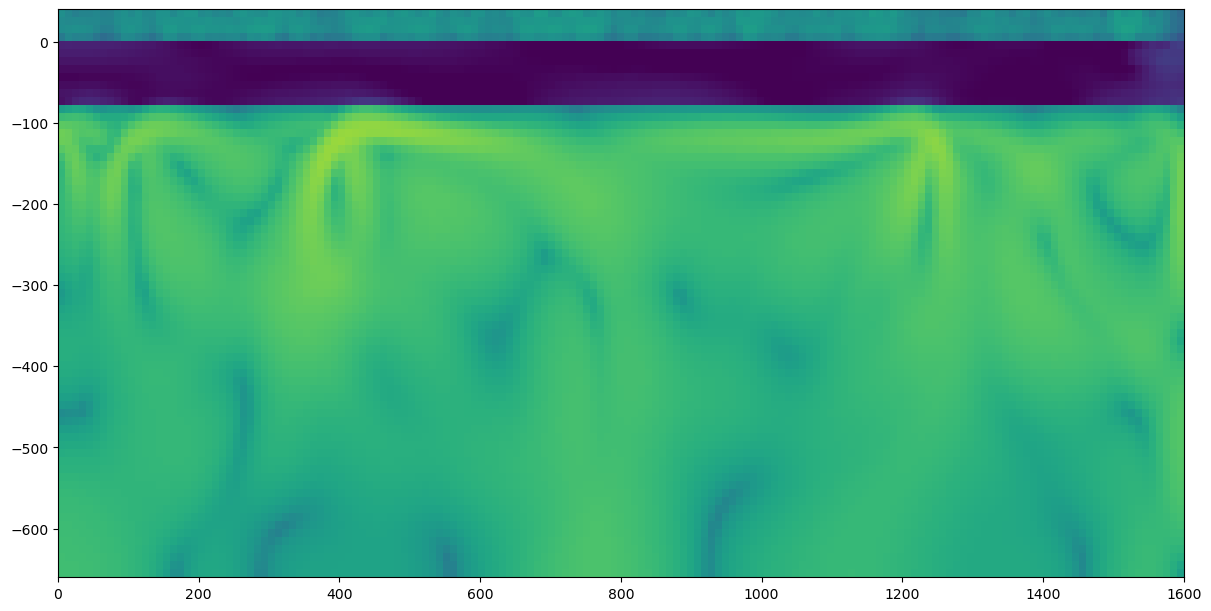

In [165]:
properties = [#Properties from mandyoc. Comment/uncomment to select with ones you would like to plot
#              'density',
#              'radiogenic_heat',
#              'lithology',
#              'pressure',
#              'strain',
             'strain_rate',
#              'temperature',
#              'temperature_anomaly',
#              'surface',
#              'viscosity',
#              'vs_anomaly'
             ]

t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = 50#int(t0)
end = 51 #int(dataset.time.size - 1)
step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

for i in range(start, end, step):
    instant = float(dataset.time[i])
    data = dataset.isel(time=i)
    for prop in properties:
        plot_data(data, prop)


<xarray.DataArray 'strain_rate' (x: 161, z: 71)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     float64 125.0
    step     int32 25000
  * x        (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.58e+06 1.59e+06 1.6e+06
  * z        (z) float64 -7e+05 -6.9e+05 -6.8e+05 -6.7e+05 ... -2e+04 -1e+04 0.0

In [114]:
np.shape(dataset.strain_rate)

(161, 71)